# Цена парковки

### Проект выполнен Багаевым Рамазаном и Толстых Еленой на основе статьи https://arxiv.org/ftp/arxiv/papers/1601/1601.06515.pdf  

## Описание задачи

###### Введем следующие обозначения:

$x$ - доля людей в городе, пользующихся личным транспортом ($x \in [0, 1]$);                                                   
$a$ - постоянные расходы (топливо, плата за парковку и т.д.);                                                                  
$p$ - индивидуальная оценка человеком стоимости минуты своего времени в рублях;                                            
$T(x)$ - функция, характеризующая то, как пользователи транспортной сети оценивают свои временные затраты на дорогу,          
в стандартном виде $T(x) = T_0 + \gamma x^4$, где $\gamma$ - некоторый параметр                                                

Тогда расходы на пользование личным транспортом можно описать следующей формулой:                                          
 $A_p(x) = a + p*T(x)$
 
Аналогично ежедневные потери людей, пользующихся общественным транспортом можно записать как                       
 $B_p(x) = b_1 + p b_2$,                                                                                     
 где  $b_1$ - постоянные расходы (например, цена билета), $b_2$ - время в пути (считаем постоянным для общественного транспорта)
 
 Пусть $p \in (1, 10) \frac{руб}{мин}$.   Введем $x(p)$ - долю жителей города, оценивающих минуту своего времени не менее, чем в $p$ рублей.    
 Будем считать эту зависимость степенной: $x(p) = p^{-\eta}, \eta \in [1, 2]$ 
 
 При этом, равновесие находится из условия $A_p(x) = B_p(x)$, то есть, в итоге, получаем:
 
 $p(x) = \frac{a - b_1}{b_2 - T(x)}$
 
 
##### Теперь наложим ограничения на параметры $a$, $b_1$, $b_2$, $T(1)$ и $p$:                                                             
1. $b_1 < a$ : цена проезда на общественном транспорте меньше расходов на топливо;                                        
2. $T(1) < b_2$: "на машине всегда быстрее"   
(здесь важно понимать, что оценка времени человеком, использовавшим личный транспорт, не эквивалентна оценке времени человеком, пользовавшимся общественным транспортом из-за учёта комфорта);             
3. $a + p_{max} T(1) < b_1 + p_{max} b_2$: как минимум один человек воспользуется личным транспортом;                           
4. $a + p_{min} T(0) > b_1 + p_{min} b_2$: как минимум один человек воспользуется общественным транспортом

Также мы предполагаем, что люди, принимая решения о том, каким транспортом им сегодня воспользоваться, используют информацию о состоянии на дорогах за предыдущий день. Тогда на $(k + 1)$-ый день доля людей, решивших воспользоваться личным транспортом равна $x^{k + 1} = x(p(x^{k}))$.

В случае, когда статистики за предыдущий день нет, человек принимает решение случайно: $x^0 \sim U[0, 1]$
 
 
 
 
 

## Расчёты

In [1]:
import random
from matplotlib import pyplot as plt
import numpy as np

Определим функции необходимые для расчётов

In [2]:
def T(x):
    return T0 + gamma * x ** 4
def P(x, a):
    return (a - b1) / (b2 - T(x))
def X(p):
    return p ** (-eta)

In [3]:
def check():
    print(T(1) < b2)

Оценим небходимые коэффициенты для Москвы. Размер населения является известной величиной, возьмём её порядка 12 миллионов. 

In [4]:
N = 12000000


Время пути в машине в худшем случее порядка ~2 часов, без активного движения ~45 минут.

In [5]:
gamma = 75
T0 = 45

Для общественного транспорта

In [6]:
b2 = 150
b1 = 50

Степень в распределении Ципфа-Парето

In [7]:
eta = 1

Максимальный и минимальный доход

In [8]:
pmax = 50
pmin = 1

Проверим выполняются ли обговорённые условия, для существующих велечин

In [9]:
check()

True


Функции, которые будут проводить расчёты

In [10]:
def carryOnOneExperiment(a):
    xprev = -1
    xcur = random.random()
    counter = 0
    tol = 1/N
    while(abs(xprev - xcur) > tol):
        counter += 1
        xprev = xcur
        xcur = X(P(xcur, a))
    return (counter, xcur)


In [11]:
def carryOnExperiments(number, a):
    experimentDays = 0
    x = 0
    for i in range(0, number):
        res = carryOnOneExperiment(a)
        experimentDays += res[0]
        x += res[1]
    return (experimentDays/number, x/number)

In [12]:
def printResult(result):
    print("В среднем равновесие наступит через {} дней,".format(result[0]))
    print("Доля людей на личном транспорте {}%".format(int(result[1] * 100)))

Посмотрим на результаты для фиксированного `a = 200` (размера фиксированого расхода для автомобилистов), удовлетворяющего условиям

In [13]:
printResult(carryOnExperiments(100, 200))

В среднем равновесие наступит через 21.85 дней,
Доля людей на личном транспорте 62%


Определим из условий допустимые значения `a`

In [14]:
amin = b1 + pmin*b2 - pmin*T(0)+1
amax = b1 + pmax*b2 - pmax*T(1)-1
print(amin)
print(amax)

156
1549


Найдём зависимость `x` от `a`

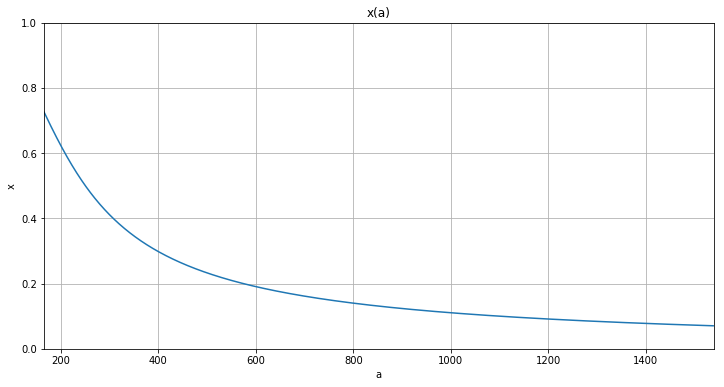

In [15]:
sample = list()
a = amin + 10
step = 1
while(a < amax - 10):
    res = carryOnOneExperiment(a)
    sample.append((a, res[1]))
    a += step
a, x = np.array(sample).T
plt.figure(figsize=(12, 6))
plt.xlim(amin + 10, amax - 10)
plt.ylim(0, 1)
plt.grid()
plt.xlabel('a')
plt.ylabel('x')
plt.title('x(a)')
plt.plot(a, x)
plt.show()

## Оптимальный тариф

In [16]:
def plotL():
    plt.figure(figsize=(12, 6))
    plt.xlim(amin + 10, amax - 10)
    plt.grid()
    plt.xlabel('a')
    plt.ylabel('L')
    plt.title('L(a)')
    plt.plot(a, L)
    plt.show()
    print('Оптимальный тариф: {} рублей'.format(int(a[np.argmin(L)])))

Попробуем сначало минизировать расходы населения, $L(a) = \int_0^1 \min(a + p(t) T(x(a)), b_1 + p(t) b_2) dt$ $\rightarrow \min$ 

In [17]:
xi = np.linspace(pmax ** (-eta), pmin ** (-eta), 1000)
ps = xi ** (-1 / eta)
L = np.empty(len(a))
for j, (a_, x_) in enumerate(zip(a, x)):
    L[j] = np.mean(np.fmin(a_ + ps * T(x_), b1 + ps * b2))

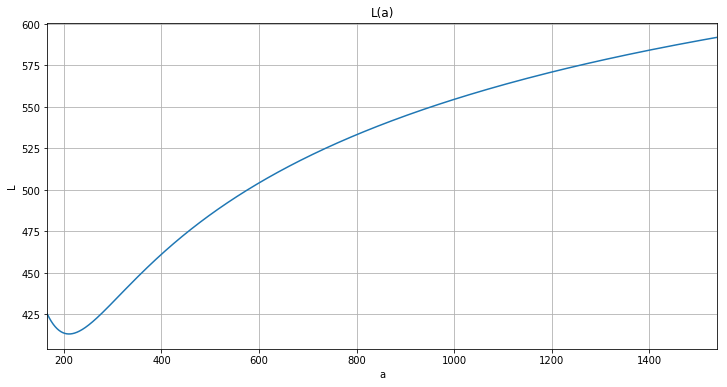

Оптимальный тариф: 211 рублей


In [18]:
plotL()

Максимизируем доходы государства, которые представляют собой доходы с парковки и доходы с общественного транспорта

In [19]:
L = -x * a -(1-x)*b1

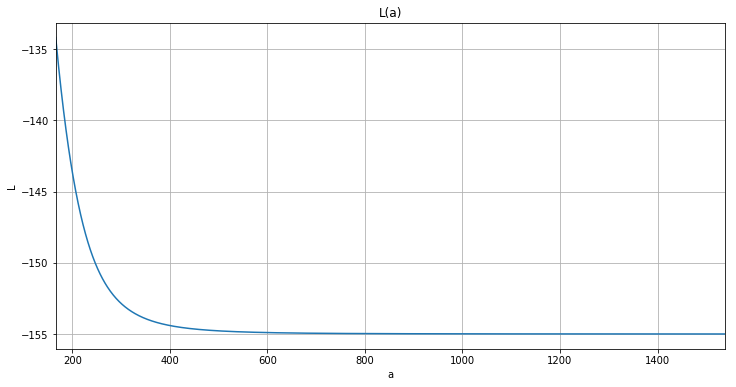

Оптимальный тариф: 1538 рублей


In [20]:
plotL()

Представим, что государство также обеспокоенно за трату времени людьми

In [21]:
L = -x*a - (1-x)*b1 + (x * T(x) + (1 - x)*b2)

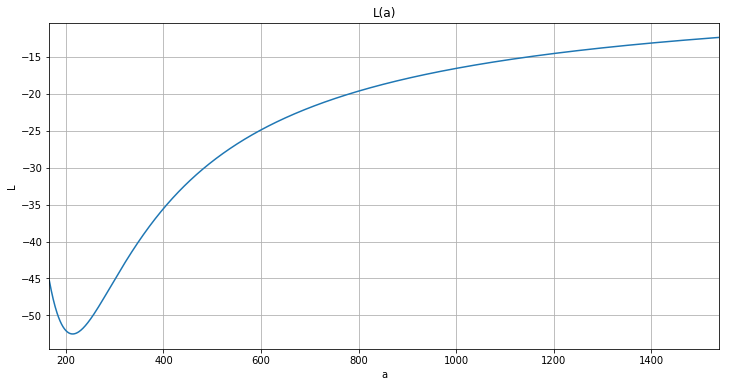

Оптимальный тариф: 214 рублей


In [22]:
plotL()

Позволим государству выбирать, насколько рассходы людей важны для них

In [23]:
koef = 10
L = -x*a - (1-x)*b1 + (x * T(x) + (1 - x)*b2)/koef

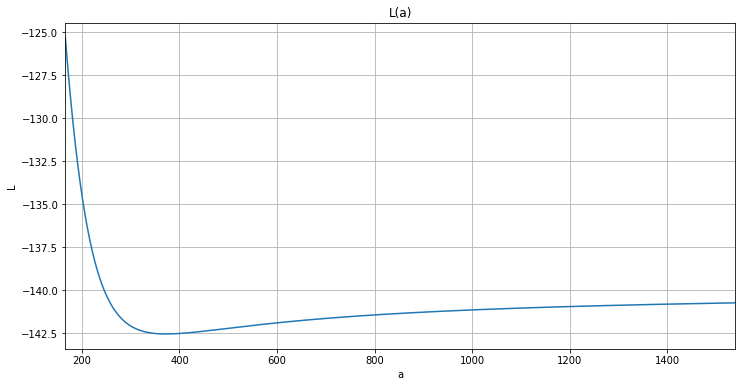

Оптимальный тариф: 373 рублей


In [24]:
plotL()